# Develop baseline for comparison by using bilinear interpolation
Later on, we also want to compare to CRM model data

- Do we interpolate on raw precip data or on log-scaled data? 
- Let's use the raw precip data. 
- let's evaluate on the whole domain, where the radar coverage is good 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import xskillscore as xs
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
import hvplot.xarray
import cartopy.crs as crs
# add src directory
import sys
sys.path.append('..')
from src.dataloader import *
from src.evaluation import compare_fields, get_eval_mask, get_baseline, compute_eval_metrics

In [32]:
from dask.diagnostics import ProgressBar

In [3]:
ds = TiggeMRMSDataset(
    tigge_dir='/datadrive/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir='/datadrive/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn='/datadrive/mrms/4km/RadarQuality.nc',
    val_days=7,
    split='valid',
    tp_log=0, scale=False, lead_time=12,
) 

In [4]:
tigge = ds.tigge.isel(variable=0)
mrms = ds.mrms
baseline = tigge.interp_like(mrms)

In [5]:
ds.min

AttributeError: 'TiggeMRMSDataset' object has no attribute 'min'

In [4]:
def compare_fields(X, y_G = None, y_b = None, y=None, 
                   levels = np.arange(0,10,0.1), cmap='viridis' ): 
    """ Compare precipitation fields 
    X: TIGGE field 
    y_G: downscaled field from Generator/CNN, ... 
    y_b: baseline 
    y: radar precip
    """
    
    fig, axs = plt.subplots(1, 4, figsize=[20,4], sharey=True, squeeze=True)
    settings = dict(levels=levels, cmap=cmap)

    X.plot(ax=axs[0], **settings)
    axs[0].set_title('Tigge original')
    
    if y_G:
        y_G.plot(ax=axs[3], **settings)
    axs[1].set_title('downscaled')
    
    y_b.plot(ax=axs[2], **settings)
    axs[2].set_title('baseline')
    
    y.plot(ax=axs[3], **settings)
    axs[3].set_title('MRMS')
    
    return fig, axs


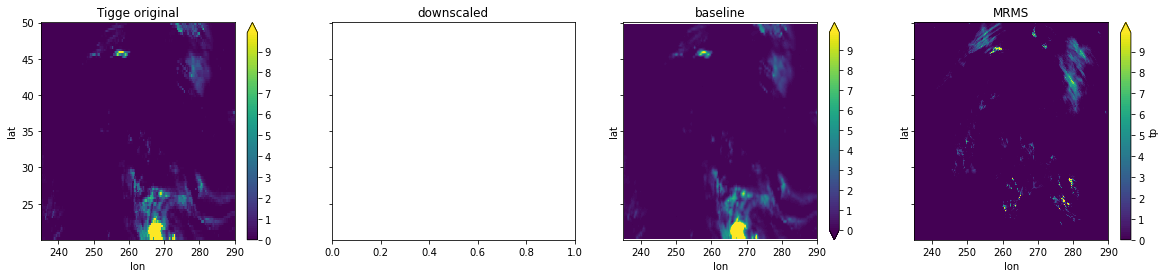

In [31]:
ti=17
_,_ = compare_fields(tigge.isel(valid_time=ti), y_b =baseline.isel(valid_time=ti), 
               y = mrms.isel(time=ti))

In [5]:
import xskillscore as xs


In [ ]:
xr.interp_like()

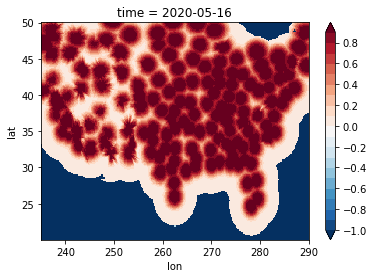

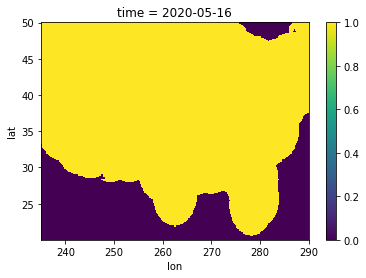

In [14]:
rq = xr.open_dataarray('/datadrive/mrms/4km/RadarQuality.nc')
rq['lat']=mrms.lat
rq['lon']=mrms.lon

eval_mask = rq>-1
rq.plot(levels=np.arange(-1,1,0.1))
plt.figure()
(rq>-1).plot()

In [11]:
mrms.chunk(dict(time=1))

<xarray.DataArray 'tp' (time: 70, lat: 750, lon: 1376)>
dask.array<xarray-<this-array>, shape=(70, 750, 1376), dtype=float32, chunksize=(1, 750, 1376), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-05-01 ... 2020-09-07T12:00:00
  * lat      (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon      (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0

In [18]:
baseline = baseline.rename({'valid_time':'time'})


rmse = xs.rmse(baseline.chunk(dict(time=1)).where(eval_mask), 
        mrms.chunk(dict(time=1)).where(eval_mask), dim=['lon', 'lat'], skipna=True)

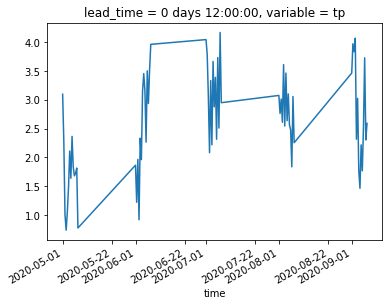

In [21]:
rmse.compute().plot()

In [23]:
baseline = baseline.chunk({'time':1})
mrms = mrms.chunk({'time':1}) 

1031250

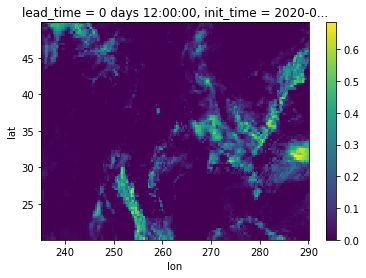

In [8]:
tigge.isel(valid_time=30, variable = 0).plot()

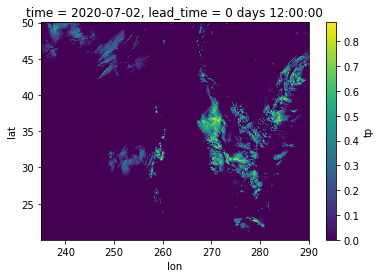

In [15]:

mrms.isel(time=30).plot()

In [17]:
egg = tigge.isel(valid_time=30, variable = 0)

egg = egg.interp_like(mrms.isel(time=30))
egg

<xarray.DataArray (lat: 750, lon: 1376)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    init_time   datetime64[ns] 2020-07-01T12:00:00
    valid_time  datetime64[ns] 2020-07-02
    variable    <U2 'tp'
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0

In [48]:
X,y = ds[1405]


is xarray


In [31]:
mrms.isel(time=30)
tigge

<xarray.DataArray (variable: 1, valid_time: 70, lat: 93, lon: 172)>
array([[[[7.41337463e-02, 6.79330109e-03, 0.00000000e+00, ...,
          3.21149081e-01, 3.20083767e-01, 3.24588925e-01],
         [2.11130425e-01, 1.72829062e-01, 1.26282126e-01, ...,
          3.18425208e-01, 3.23173970e-01, 3.31613570e-01],
         [1.00319646e-01, 1.79466113e-01, 1.48915485e-01, ...,
          3.35066557e-01, 3.53709787e-01, 3.68517220e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.63847033e-03, 3.38160340e-03, 2.45916867e-03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 4.65222955e-04, 1.52078923e-03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 4.71754320e-04]],

        [[1.41808215e-07, 1.07546700e-02, 3.32085565e-02, ...,
          4.45510745e-01, 4.18250233e-01, 3.99154723e-01],
         [1.14575529e-03, 0.00000000e+00, 6.83643892e-02, ...,
          3.94398928e-01, 3.84114653e-01, 3.79680693e-01],
         [2.13190094e-02, 2.71927658e-03, 7.02336256e-04, ...,
          3.80482852e-01, 3.78187209e-01, 3.76496881e-01],
...
          2.06649490e-03, 1.18068075e-02, 1.81711018e-02],
         [6.77888573e-04, 0.00000000e+00, 3.52906442e-04, ...,
          1.72831980e-03, 3.86587973e-03, 9.03890841e-03],
         [1.65508885e-03, 4.51216387e-04, 0.00000000e+00, ...,
          7.59980932e-04, 2.47669872e-03, 4.57839761e-03]],

        [[0.00000000e+00, 3.73761315e-04, 7.93481653e-04, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 9.05188608e-06, 3.84117186e-04, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.58254299e-02, 1.12635177e-02, 7.87299685e-03, ...,
          8.13903380e-03, 6.70791278e-03, 6.14391966e-03],
         [8.23383033e-03, 1.35262599e-02, 8.13435949e-03, ...,
          1.24877151e-02, 4.98851342e-03, 1.07665767e-03],
         [3.78445908e-02, 3.55542898e-02, 3.71765420e-02, ...,
          1.99720562e-02, 9.64622945e-03, 7.07260380e-03]]]],
      dtype=float32)
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    init_time   (valid_time) datetime64[ns] 2020-04-30T12:00:00 ... 2020-09-07
  * lon         (lon) float64 235.2 235.5 235.8 236.2 ... 289.3 289.6 289.9
  * lat         (lat) float64 49.68 49.36 49.04 48.72 ... 21.2 20.88 20.56 20.24
  * valid_time  (valid_time) datetime64[ns] 2020-05-01 ... 2020-09-07T12:00:00
  * variable    (variable) <U2 'tp'

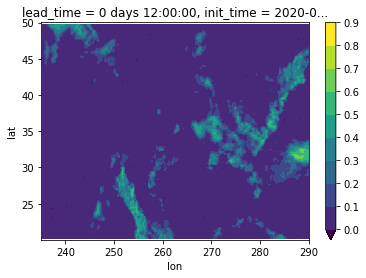

In [20]:
egg.plot(levels=np.arange(0,1,0.1),cmap='viridis')

In [5]:
def get_baseline(X, y, kind = 'interpol', 
                 X_lon=None, X_lat=None, y_lon = None, y_lat =None,
                 **kws ): 
    """ Function computes baseline, i.e. interpolates X onto the grid of y. 
    
    This is probably overkill for now, but might be handy later on when we have different baselines

    1. If X and y are given as numpy arrays, transform to xarray 
    2. Apply interpolation
    
    X: Tigge dataset, or sample. Can be xarray format or numpy
    y: Target radar dataset or radar sample corresponding to X. Can be xarray format or numpy 
    kind: kind of baseline to use. So for only linear interpolation is used
    X_lon,X_lat: arrays of longitudes and latitudes for X. Need to be specified only if X is numpy array.
    y_lon,y_lat: arrays of longitudes and latitudes for y. Need to be specified only if y is numpy array.
    
    Returns: baseline downscaled X to the grid of y
    """
    # make sure we have xarrays as inputs, makes interpolation easier
    if type(X) != xr.DataArray:
        X = xr.DataArray(data=X, dims=["lat", "lon"], 
                         coords=dict(lon=("lon", X_lon), lat=("lat", X_lat)))
        # iterative function call:
        return get_baseline(X,y,kind=kind,**kws) 
    if type(y) != xr.DataArray:
        y = xr.DataArray(data=y, dims=["lat", "lon"], 
                         coords=dict(lon=("lon", y_lon), lat=("lat", y_lat)))
        # iterative function call:
        return get_baseline(X,y,kind = kind, **kws)
    
    assert type(X) == xr.DataArray, 'X is not an xarray.'
    assert type(y) == xr.DataArray, 'y is not an xarray.'
    #assert X.dims == y.dims, 'Dimensions of X and y do not match.'
    
        
    # Do the interpolation 
    y_baseline = X.interp_like(y, kwargs = dict(fill_value='extrapolate')) 
    # fill_value: for scipy interoplate, extrapolates values at the boundaries, so no Nans appear! 
    
    assert y_baseline.shape == y.shape, 'y_baseline and y do not have the same size!'
    return y_baseline

# Continue

In [85]:
baseline = get_baseline(tigge, mrms)

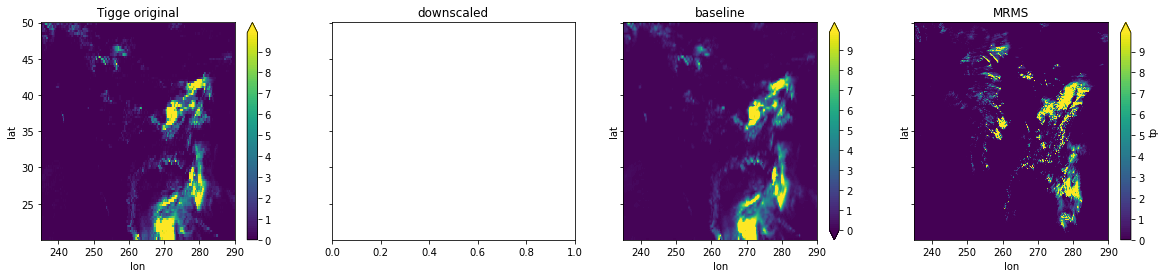

In [88]:
ti=22
_,_ = compare_fields(tigge.isel(valid_time=ti), y_b =baseline.isel(valid_time=ti), 
               y = mrms.isel(time=ti))

In [82]:
test = tigge.interp_like(mrms, kwargs = dict(fill_value='extrapolate'))

In [6]:
def get_eval_mask(criterion='radarquality', rq_threshold = -1, 
                rq_fn = '/datadrive/mrms/4km/RadarQuality.nc', ds = None): 
    """ Returns a lon-lat mask which area we evaluate on. 
        The radar quality mask is used to determine this. 

        criterion: criterion to apply. ('radarquality', 'patchareas')
        rq_threshold: threshold for 'radarquality'-criterion.   
                    -1 covers everything with radar availability. 
                    Larger thresholds require higher quality. 
        ds: If patchareas criterion, the tiggemrmsm object is required 
                    to get the radarmask for the patches.

        Returns: boolean xr-dataarray, with same lon-lat dimensions 
            as the radar data. 
    """
    if criterion =='radarquality': # use rq>rq-threshold as criterion 
        rq = xr.open_dataarray(rq_fn)
        eval_mask = rq>rq_threshold
    if criterion == 'patchareas': 
        eval_mask = ds.rqmask
    return eval_mask

In [106]:
eval_mask = get_eval_mask()
eval_mask['lat']=mrms.lat # somehow rq has weird lon lat values! 
eval_mask['lon']=mrms.lon
eval_mask

<xarray.DataArray (lat: 750, lon: 1376)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     datetime64[ns] ...
  * lat      (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon      (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0

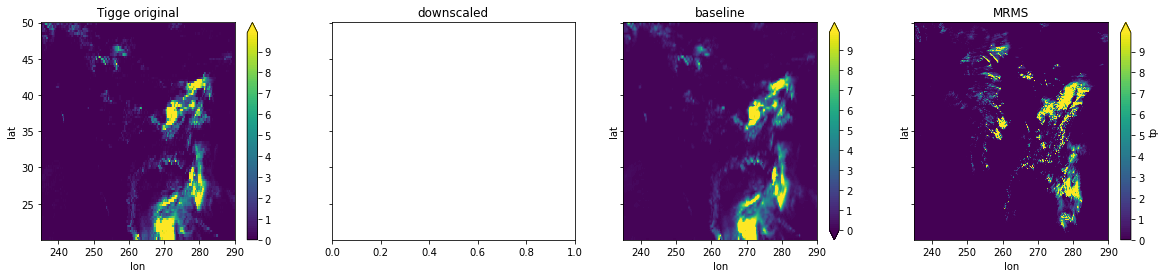

In [102]:
ti=22
_,_ = compare_fields(tigge.isel(valid_time=ti), y_b =baseline.isel(valid_time=ti), 
               y = mrms.isel(time=ti))

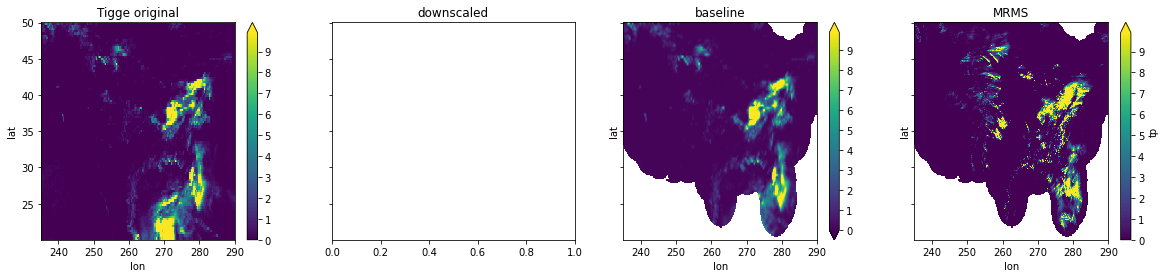

In [135]:
ti=22
_,_ = compare_fields(tigge.isel(valid_time=ti), y_b =baseline.where(eval_mask).isel(valid_time=ti), 
               y = mrms.isel(time=ti).where(eval_mask))

In [111]:
tigge.isel(valid_time=ti)#.where(eval_mask)

<xarray.DataArray (lat: 93, lon: 172)>
array([[1.3524932e+00, 1.4238667e-01, 6.2703872e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0896751e+00, 8.7900746e-01, 1.1589262e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.2467923e+00, 7.9704684e-01, 8.5312176e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [3.2832678e-03, 5.3122640e-04, 3.8384218e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.7975526e-03, 0.0000000e+00, 8.1078708e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.3713418e-03, 9.2644629e-04, 3.6989022e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    init_time   datetime64[ns] 2020-06-04T12:00:00
  * lon         (lon) float64 235.2 235.5 235.8 236.2 ... 289.3 289.6 289.9
  * lat         (lat) float64 49.68 49.36 49.04 48.72 ... 21.2 20.88 20.56 20.24
    valid_time  datetime64[ns] 2020-06-05
    variable    <U2 'tp'

<xarray.DataArray (lat: 750, lon: 1376)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     datetime64[ns] 2020-05-16
  * lat      (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon      (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0

In [143]:
# rechunking necessary for performance 
#baseline = baseline.rename({'valid_time':'time'}).chunk({'time':1})
#mrms = mrms.chunk({'time':1}) 
# RMSE 
rmse = xs.rmse(baseline.where(eval_mask), 
    mrms.where(eval_mask), dim=['lon', 'lat'], skipna=True)

In [142]:
rmse.compute()

<xarray.DataArray (time: 86)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    lead_time  timedelta64[ns] 12:00:00
    init_time  (time) datetime64[ns] 2020-04-30T12:00:00 ... 2020-11-30T12:00:00
  * time       (time) datetime64[ns] 2020-05-01 ... 2020-12-01
    variable   <U2 'tp'

In [9]:
metrics = compute_eval_metrics(baseline, mrms, eval_mask)
metrics

NameError: name 'eval_mask' is not defined

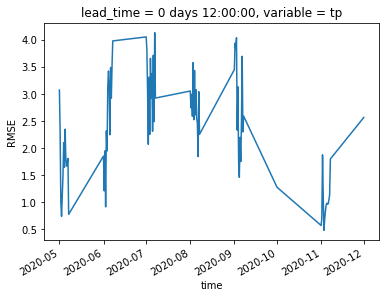

In [158]:
metrics['RMSE'].plot()

In [159]:
ds.rqmask

<xarray.DataArray (lat: 5, lon: 10)>
array([[ True,  True,  True,  True,  True,  True,  True, False, False,
        False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
        False],
       [False, False, False, False, False,  True, False, False,  True,
        False]])
Coordinates:
    time     datetime64[ns] 2020-05-16
  * lat      (lat) float64 47.44 42.32 37.2 32.08 26.96
  * lon      (lon) float64 237.6 242.7 247.8 252.9 ... 268.3 273.4 278.5 283.6

In [161]:
interpds.mrms.isel(time=0)

<xarray.DataArray 'tp' (lat: 750, lon: 1376)>
array([[0.       , 0.       , 0.       , ..., 5.7875   , 5.89375  ,
        6.0062504],
       [0.       , 0.       , 0.       , ..., 6.08125  , 6.3187504,
        6.1875   ],
       [0.       , 0.       , 0.       , ..., 6.3625   , 6.49375  ,
        6.54375  ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2020-05-01
  * lat      (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon      (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0

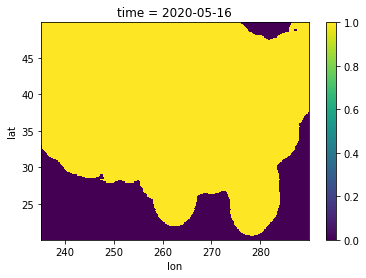

In [165]:
rq_fn = '/datadrive/mrms/4km/RadarQuality.nc'
rq = xr.open_dataarray(rq_fn)
rq = rq.isel(lat=slice(ds.pad_mrms, -ds.pad_mrms or None), lon=slice(ds.pad_mrms, -ds.pad_mrms or None))
(rq>=0).plot()

In [8]:
ds = TiggeMRMSDataset(
tigge_dir='/datadrive/tigge/32km/',
tigge_vars=['total_precipitation'],
mrms_dir='/datadrive/mrms/4km/RadarOnly_QPE_06H/',
rq_fn='/datadrive/mrms/4km/RadarQuality.nc',
val_days=7,
split='valid',
tp_log=0, scale=False,
lead_time=12, # Sofar, this can not yet handle arrays of lead time. 
) 


# 2. Compute baseline 
tigge = ds.tigge.isel(variable=0)
mrms = ds.mrms
baseline = get_baseline(tigge, mrms)


# 3. evaluation mask
eval_mask = get_eval_mask()
eval_mask['lat']=mrms.lat # somehow rq has weird lon lat values! 
eval_mask['lon']=mrms.lon

# 4. compute metrics: 
metrics = compute_eval_metrics(baseline, mrms, eval_mask)

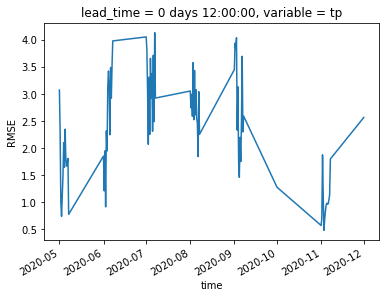

In [13]:
metrics.RMSE.plot()

# Develop FSS metrics

In [58]:
def compute_integral_table(field) :
    return field.cumsum(1).cumsum(0)


def integral_filter(field, n, table=None) :
    """
    Fast summed area table version of the sliding accumulator.
    :param field: nd-array of binary hits/misses.
    :param n: window size.
    """
    w = n // 2
    if w < 1. :
        return field
    if table is None:
        table = compute_integral_table(field)

    r, c = np.mgrid[ 0:field.shape[0], 0:field.shape[1] ]
    r = r.astype(np.int)
    c = c.astype(np.int)
    w = np.int(w)
    r0, c0 = (np.clip(r - w, 0, field.shape[0] - 1), np.clip(c - w, 0, field.shape[1] - 1))
    r1, c1 = (np.clip(r + w, 0, field.shape[0] - 1), np.clip(c + w, 0, field.shape[1] - 1))
    integral_table = np.zeros(field.shape).astype(np.int64)
    integral_table += np.take(table, np.ravel_multi_index((r1, c1), field.shape))
    integral_table += np.take(table, np.ravel_multi_index((r0, c0), field.shape))
    integral_table -= np.take(table, np.ravel_multi_index((r0, c1), field.shape))
    integral_table -= np.take(table, np.ravel_multi_index((r1, c0), field.shape))
    return integral_table



def fss(fcst, obs, threshold, window, fcst_cache=None, obs_cache=None):
    """
    Compute the fraction skill score using summed area tables .
    :param fcst: nd-array, forecast field.
    :param obs: nd-array, observation field.
    :param window: integer, window size.
    :return: tuple of FSS numerator, denominator and score.
    """
    fhat = integral_filter( fcst > threshold, window, fcst_cache )
    ohat = integral_filter( obs  > threshold, window, obs_cache  )

    num = np.nanmean(np.power(fhat - ohat, 2))
    denom = np.nanmean(np.power(fhat, 2) + np.power(ohat, 2))
    return num, denom, 1.-num/denom

def fss_frame(fcst, obs, windows, levels):
    """
    Compute the fraction skill score data-frame.
    :param fcst: nd-array, forecast field.
    :param obs: nd-array, observation field.
    :param window: list, window sizes.
    :param levels: list, threshold levels.
    :return: list, dataframes of the FSS: numerator,denominator and score.
    """
    num_data, den_data, fss_data = [], [], []
    #print(fcst.shape)
    #print(obs.shape)
    for level in levels:
        ftable = compute_integral_table( fcst > level )
        otable = compute_integral_table( obs  > level )
        _data = [fss(fcst, obs, level, w, ftable, otable) for w in windows]
        num_data.append([x[0] for x in _data])
        den_data.append([x[1] for x in _data])
        fss_data.append([x[2] for x in _data])
    return np.array(fss_data) #pd.DataFrame(fss_data, index=levels, columns=windows)
# ----------------------------------

In [45]:
thresholds=[1.]
scales=[ 21, 41]

ti = 10
fcst = baseline.isel(valid_time=ti).where(eval_mask).values
obs = mrms.isel(time=ti).where(eval_mask).values


out = fss_frame (fcst, obs, windows=scales, levels = thresholds)

(750, 1376)
(750, 1376)


In [49]:
out.shape

(1, 2)

In [64]:
fcst = baseline.where(eval_mask)
del fcst['time']
fcst = fcst.rename({'valid_time':'time'})
    
# rechunking necessary for performance 

fcst = fcst.chunk({'time':20})
    
obs = mrms.where(eval_mask)
obs = obs.chunk({'time':20}) 


from dask.diagnostics import ProgressBar

#out = fss_frame (fcst, obs, windows=scales, levels = thresholds)
test = xr.apply_ufunc(fss_frame,fcst, obs, input_core_dims=[[ 'lat', 'lon'], ['lat', 'lon']],
               output_core_dims=[['thresholds','scales']], 
               output_dtypes=[fcst.dtype],
               dask_gufunc_kwargs = dict(output_sizes= {'scales':len(scales), 'thresholds': len(thresholds)},),
               vectorize =True, 
               dask='parallelized',
               kwargs = dict(windows=scales, levels = thresholds))
test['thresholds'] = thresholds
test['scales'] = scales

In [65]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    test = test.compute()


[########################################] | 100% Completed | 13.2s


In [94]:
test

<xarray.DataArray (time: 86, thresholds: 1, scales: 2)>
array([[[0.81350118, 0.8620245 ]],

       [[0.74327653, 0.79723575]],

       [[0.67372974, 0.74748441]],

       [[0.78168653, 0.84715819]],

       [[0.79029785, 0.85549787]],

       [[0.74038578, 0.81281792]],

       [[0.73982936, 0.81689552]],

       [[0.81420097, 0.87564539]],

       [[0.75189411, 0.81838814]],

       [[0.85780988, 0.9163869 ]],

...

       [[0.61339758, 0.65573717]],

       [[0.69236711, 0.74351139]],

       [[0.59742005, 0.64223575]],

       [[0.37368013, 0.37383758]],

       [[0.47256734, 0.49612565]],

       [[0.52340919, 0.54913546]],

       [[0.55420158, 0.5935216 ]],

       [[0.47387347, 0.50838099]],

       [[0.51185644, 0.54939307]],

       [[0.82538327, 0.86435679]]])
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    init_time   (time) datetime64[ns] 2020-04-30T12:00:00 ... 2020-11-30T12:0...
  * time        (time) datetime64[ns] 2020-05-01 ... 2020-12-01
    variable    <U2 'tp'
  * thresholds  (thresholds) float64 1.0
  * scales      (scales) int64 21 41

In [90]:
def compute_eval_metrics(fcst, obs, eval_mask = None, metrics = ['RMSE', 'FSS'], fss_scales=[41,61], fss_thresholds = [1., 5.] ): 
    """ Function to compute evaluation metrics to compare a forecast with observations
    fcst: xr-array of the forecast, e.g. the interpolation baseline or the downscaled forecast
    obs: xr-array fo observations, i.e. radar data 
    eval_mask: 2d boolean mask to apply the evaluation on, i.e. radar quality mask
    metrics: list of metrics to consider
    
    fss_scales: list of spatial scales to use for the FSS calculation
    fss_thresholds: list of precip thresholds to use for the FSS calculation
    
    Returns: xr-dataset with different metrics as different variables   
        Note that this function utilizes dask and returns xarrays with dask arrays. Use
    """
    
    
    if (not 'time' in fcst.dims):
        # fcst and obs have different time dimension names --> need to be the same
        fcst = fcst.rename({'valid_time':'time'})
        
    # rechunking necessary for performance 
    fcst = fcst.chunk({'time':1})
    obs = obs.chunk({'time':1}) 
    
    # apply eval mask: 
    if eval_mask is not None:
        fcst = fcst.where(eval_mask)
        obs = obs.where(eval_mask)
        
    metrics_ds = xr.Dataset()
    # RMSE 
    if 'RMSE' in metrics: 
        rmse = xs.rmse(fcst, 
            obs, dim=['lon', 'lat'], skipna=True)
        metrics_ds['RMSE'] = rmse
        
    if 'FSS' in metrics: # maybe there is a way to implement this faster?
        from dask.diagnostics import ProgressBar

        fss_da = xr.apply_ufunc(fss_frame, fcst, obs, input_core_dims=[[ 'lat', 'lon'], ['lat', 'lon']],
                       output_core_dims=[['thresholds','scales']], 
                       output_dtypes=[fcst.dtype],
                       dask_gufunc_kwargs = dict(output_sizes= {'scales':len(fss_scales), 'thresholds': len(fss_thresholds)},),
                       vectorize =True, dask='parallelized',
                       kwargs = dict(windows=fss_scales, levels = fss_thresholds))
        fss_da['thresholds'] = np.array(fss_thresholds)
        fss_da['scales'] = np.array(fss_scales)
        #with ProgressBar(minimum=1): 
            #fss_da = fss_da.compute()
        metrics_ds['FSS'] = fss_da
    
    return metrics_ds

In [97]:
metrics = compute_eval_metrics(baseline, mrms, eval_mask)
with ProgressBar(minimum=1): 
    metrics.load()

[########################################] | 100% Completed | 26.3s


In [96]:
metrics.load()

<xarray.Dataset>
Dimensions:     (scales: 2, thresholds: 2, time: 86)
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    init_time   (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time        (time) datetime64[ns] 2020-05-01 ... 2020-12-01
    variable    <U2 'tp'
  * thresholds  (thresholds) float64 1.0 5.0
  * scales      (scales) int64 41 61
Data variables:
    RMSE        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    FSS         (time, thresholds, scales) float64 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>

In [8]:
def get_eval_mask(criterion='radarquality', rq_threshold = -1, 
                rq_fn = '/datadrive/mrms/4km/RadarQuality.nc', ds = None): 
    """ Returns a lon-lat mask which area we evaluate on. 
        The radar quality mask is used to determine this. 

        criterion: criterion to apply. ('radarquality') 
        rq_threshold: threshold for 'radarquality'-criterion.   
                    -1 covers everything with radar availability. 
                    Larger thresholds require higher quality. 
        ds: If patchareas criterion, the tiggemrmsm object is required 
                    to get the radarmask for the patches.

        Returns: boolean xr-dataarray, with same lon-lat dimensions 
            as the radar data. 
    """
    if criterion =='radarquality': # use rq>rq-threshold as criterion 
        rq = xr.open_dataarray(rq_fn)
        eval_mask = rq>rq_threshold


    return eval_mask

# Develop F1 Score

In [142]:
ds = TiggeMRMSDataset(
tigge_dir='/datadrive/tigge/32km/',
tigge_vars=['total_precipitation'],
mrms_dir='/datadrive/mrms/4km/RadarOnly_QPE_06H/',
rq_fn='/datadrive/mrms/4km/RadarQuality.nc',
val_days=7,
split='valid',
tp_log=0, scale=False,
lead_time=12, # Sofar, this can not yet handle arrays of lead time. 
) 


# 2. Compute baseline 
tigge = ds.tigge.isel(variable=0)
mrms = ds.mrms
baseline = get_baseline(tigge, mrms)


# 3. evaluation mask
eval_mask = get_eval_mask()
eval_mask['lat']=mrms.lat # somehow rq has weird lon lat values! 
eval_mask['lon']=mrms.lon

# 4. compute metrics: 
metrics = compute_eval_metrics(baseline, mrms, eval_mask)

In [147]:
with ProgressBar():
    metrics.load()

[########################################] | 100% Completed | 48.9s


In [148]:
metrics

<xarray.Dataset>
Dimensions:         (f1_thresholds: 2, fss_scales: 2, fss_thresholds: 2, time: 86)
Coordinates:
    lead_time       timedelta64[ns] 12:00:00
    init_time       (time) datetime64[ns] 2020-04-30T12:00:00 ... 2020-11-30T...
  * time            (time) datetime64[ns] 2020-05-01 ... 2020-12-01
    variable        <U2 'tp'
  * fss_thresholds  (fss_thresholds) float64 1.0 5.0
  * fss_scales      (fss_scales) int64 41 61
  * f1_thresholds   (f1_thresholds) float64 0.1 1.0
Data variables:
    RMSE            (time) float64 3.075 2.277 1.006 0.7412 ... 1.14 1.802 2.568
    FSS             (time, fss_thresholds, fss_scales) float64 0.862 ... 0.7517
    F1-Score        (time, f1_thresholds) float64 0.745 0.6942 ... 0.7119 0.7448

In [10]:
from sklearn.metrics import f1_score

In [11]:
f1_score(obs, fcst)

<function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

In [12]:
fcst = baseline.rename({'valid_time':'time'})
fcst = fcst.chunk({'time':1})
obs = ds.mrms.chunk({'time':1})


In [20]:
threshold=0.1
ti=10
f1_score((obs.where(eval_mask)>threshold).isel(time=ti).values.ravel(), 
         (fcst.where(eval_mask)>threshold).isel(time=ti).values.ravel())

0.5920428945678433

0.5081080178359693

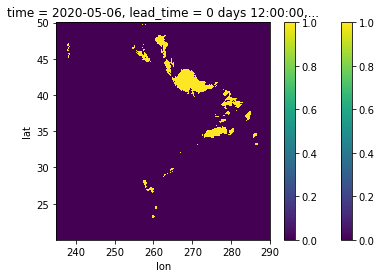

In [115]:
threshold=1.0
ti=10
o = (obs.where(eval_mask)>threshold).isel(time=ti) 
f = (fcst.where(eval_mask)>threshold).isel(time=ti)
f.plot()
tp = (o*f).plot()
f1_score(o.values.ravel(), f.values.ravel())

In [128]:
def my_f1_score(obs,fcst, thresholds, **kws): 

    assert obs.shape==fcst.shape,'Shapes of obs and fcst do not match.'
    f1_scores = [f1_score((obs>threshold).ravel(), (fcst>threshold).ravel(),**kws) for threshold in thresholds]
    return np.array(f1_scores)

In [132]:
f1_thresholds=[0.1, 1., 5]
test = xr.apply_ufunc(my_f1_score, (obs.where(eval_mask)), (fcst.where(eval_mask)), 
              input_core_dims=[['lat', 'lon'], ['lat', 'lon']], output_dtypes=[fcst.dtype],
              output_core_dims=[['thresholds']], vectorize=True, dask='parallelized',
              dask_gufunc_kwargs = dict(output_sizes= {'thresholds': len(f1_thresholds)},),
              kwargs = dict(thresholds=f1_thresholds))
test['thresholds'] = f1_thresholds

In [96]:
(fcst>1).sum().values

array(9260131)

In [133]:
with ProgressBar(): 
    test.load()

[########################################] | 100% Completed | 41.1s


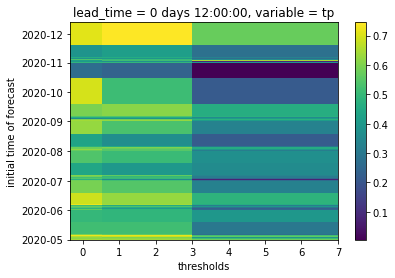

In [134]:
test.plot()

In [50]:
test.name='f1'
df = test.to_dataframe()
df

lead_time           init_time variable  \
time                thresholds                                                
2020-05-01 00:00:00 0.1        0 days 12:00:00 2020-04-30 12:00:00       tp   
                    1.0        0 days 12:00:00 2020-04-30 12:00:00       tp   
2020-05-01 12:00:00 0.1        0 days 12:00:00 2020-05-01 00:00:00       tp   
                    1.0        0 days 12:00:00 2020-05-01 00:00:00       tp   
2020-05-02 00:00:00 0.1        0 days 12:00:00 2020-05-01 12:00:00       tp   
...                                        ...                 ...      ...   
2020-11-07 00:00:00 1.0        0 days 12:00:00 2020-11-06 12:00:00       tp   
2020-11-07 12:00:00 0.1        0 days 12:00:00 2020-11-07 00:00:00       tp   
                    1.0        0 days 12:00:00 2020-11-07 00:00:00       tp   
2020-12-01 00:00:00 0.1        0 days 12:00:00 2020-11-30 12:00:00       tp   
                    1.0        0 days 12:00:00 2020-11-30 12:00:00       tp   

                                      f1  
time                thresholds            
2020-05-01 00:00:00 0.1         0.745026  
                    1.0         0.000000  
2020-05-01 12:00:00 0.1         0.642453  
                    1.0         0.000000  
2020-05-02 00:00:00 0.1         0.540371  
...                                  ...  
2020-11-07 00:00:00 1.0         0.000000  
2020-11-07 12:00:00 0.1         0.388197  
                    1.0         0.000000  
2020-12-01 00:00:00 0.1         0.711897  
                    1.0         0.000000  

[172 rows x 4 columns]

In [58]:
egg

{'a': 'f', 'b': 'test'}

In [63]:
test.max()

<xarray.DataArray ()>
array(0.)
Coordinates:
    lead_time  timedelta64[ns] 12:00:00
    variable   <U2 'tp'

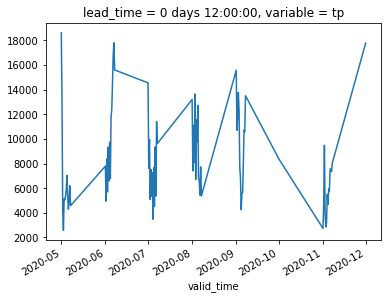

In [73]:
ds.tigge.sum(['lon','lat']).isel(variable=0).plot()

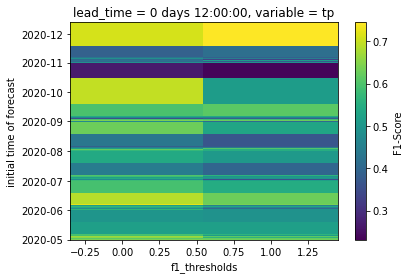

In [153]:
f1= metrics['F1-Score']
f1.plot()